# Notebook 03: Engenharia das Feature
---

## Sistema Inteligente de Retenção de Clientes - Telecomunicações

 **Objetivo:** Criar, transformar e preparar features para modelagem preditiva

- **Autor:** Ivan Ajala  
- **Dataset:** [Telco Customer Churn Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  
- **Data:** Fevereiro 2026  
- **Ferramentas:** Python, Pandas, Matplotlib, Seaborn, Plotly  
- **Versão**: 2.1 
- **Status**: Concluído

---

### Estrutura do Notebook

1. [Criação de Features Derivadas](#criacao-features)
2. [Encoding de Variáveis Categóricas](#encoding)
3. [Tratamento de Variáveis Numéricas](#tratamento)
4. [Feature Selection](#feature-selection)
5. [Balanceamento de Classes](#balanceamento)
6. [Divisão Treino/Teste](#divisao)
7. [Exportação dos Dados Preparados](#exportacao)

## 1. Configuração Inicial

----

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
from pathlib import Path
import pickle

warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## 2. Carregamento dos Dados

----

In [8]:
# Carregar dados com segmentos criados no Notebook 02

DATA_PATH = Path("../data/processed/churn_data_clean_v2.csv")
df = pd.read_csv(DATA_PATH)

print("="*80)
print("DATASET CARREGADO")
print("="*80)
print(f"\nDimensões: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
print(f"\nPrimeiras linhas:\n")
display(df.head())

DATASET CARREGADO

Dimensões: 7,043 linhas × 23 colunas

Primeiras linhas:



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Tenure_Segment,Charges_Segment
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Novo (0-12 meses),Baixo (≤$35)
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Estabelecido (25-48 meses),Médio ($35-70)
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Novo (0-12 meses),Médio ($35-70)
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Estabelecido (25-48 meses),Médio ($35-70)
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Novo (0-12 meses),Alto (>$70)


## 3. Análise Inicial das Features

----

### Tipos de dados:

In [11]:
print(df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
Tenure_Segment       object
Charges_Segment      object
dtype: object


### Resumo:

In [13]:
print(f"  • Variáveis numéricas: {df.select_dtypes(include=np.number).shape[1]}")
print(f"  • Variáveis categóricas: {df.select_dtypes(include='object').shape[1]}")

  • Variáveis numéricas: 4
  • Variáveis categóricas: 19


### Separando features e target:

In [15]:
target_col = 'Churn'
id_col = 'customerID'

print(f"\nVariável alvo: {target_col}")
print(f"Coluna ID: {id_col}")


Variável alvo: Churn
Coluna ID: customerID


<a id="criacao-features"></a>
## 4. Criação de Features Derivadas

Criando novas features baseadas em conhecimento de negócio e insights do EDA.

---

### 4.1 Features Financeiras

---

#### 1. Valor médio por mês (TotalCharges / tenure)

In [19]:
# Evitar divisão por zero
df['AvgChargesPerMonth'] = df.apply(
    lambda row: row['TotalCharges'] / row['tenure'] if row['tenure'] > 0 else row['MonthlyCharges'],
    axis=1
)

#### 2. Diferença entre MonthlyCharges e média



In [21]:
df['ChargesDifference'] = df['MonthlyCharges'] - df['AvgChargesPerMonth']

#### 3. Razão TotalCharges / MonthlyCharges (indica tempo de relacionamento)



In [23]:
df['ChargesRatio'] = df.apply(
    lambda row: row['TotalCharges'] / row['MonthlyCharges'] if row['MonthlyCharges'] > 0 else 0,
    axis=1
)

#### 4. Categorização de valor do cliente (CLV simplificado)


In [25]:
# CLV = MonthlyCharges * tenure esperado (assumindo 24 meses)
df['EstimatedCLV'] = df['MonthlyCharges'] * 24

#### 5. Flag de cliente de alto valor

In [27]:
df['HighValueCustomer'] = (df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75)).astype(int)

#### Features financeiras criadas:

In [29]:
print("  • AvgChargesPerMonth")
print("  • ChargesDifference")
print("  • ChargesRatio")
print("  • EstimatedCLV")
print("  • HighValueCustomer")

  • AvgChargesPerMonth
  • ChargesDifference
  • ChargesRatio
  • EstimatedCLV
  • HighValueCustomer


#### Visualizando Features financeiras

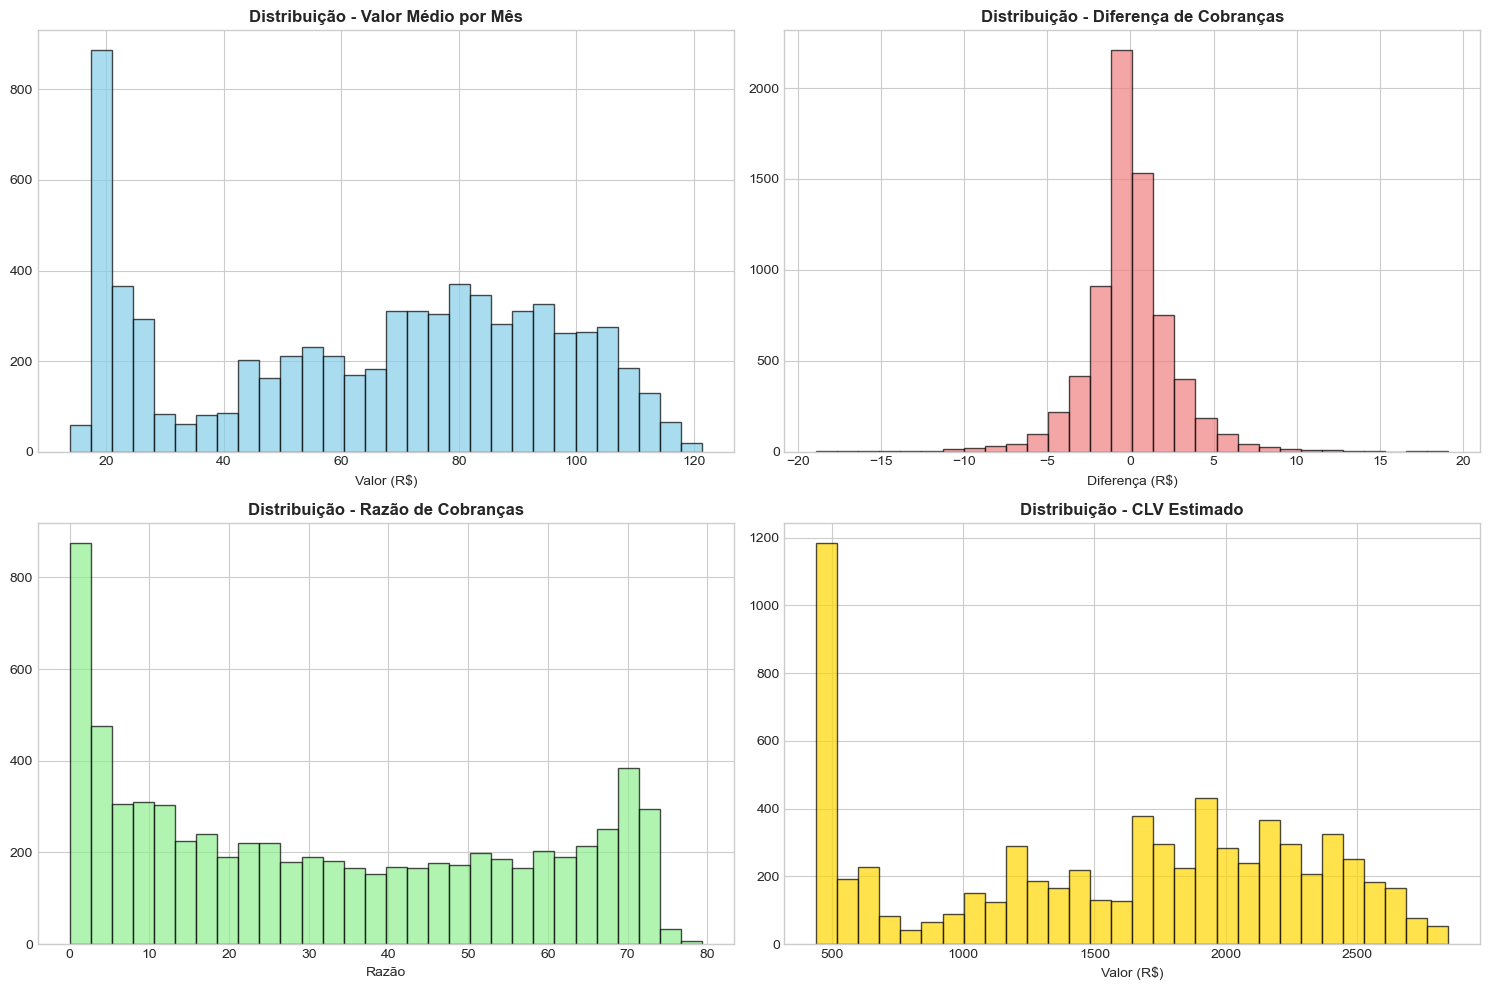

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df['AvgChargesPerMonth'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribuição - Valor Médio por Mês', fontweight='bold')
axes[0, 0].set_xlabel('Valor (R$)')

axes[0, 1].hist(df['ChargesDifference'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribuição - Diferença de Cobranças', fontweight='bold')
axes[0, 1].set_xlabel('Diferença (R$)')

axes[1, 0].hist(df['ChargesRatio'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribuição - Razão de Cobranças', fontweight='bold')
axes[1, 0].set_xlabel('Razão')

axes[1, 1].hist(df['EstimatedCLV'], bins=30, color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribuição - CLV Estimado', fontweight='bold')
axes[1, 1].set_xlabel('Valor (R$)')

plt.tight_layout()
plt.show()

### 4.2 Features de Tenure (Tempo de Relacionamento)

---

#### 1. Categorização de tenure em grupos

In [34]:
def categorize_tenure_detailed(tenure):
    if tenure <= 6:
        return 'Very_New'
    elif tenure <= 12:
        return 'New'
    elif tenure <= 24:
        return 'Intermediate'
    elif tenure <= 48:
        return 'Established'
    else:
        return 'Veteran'

df['TenureGroup'] = df['tenure'].apply(categorize_tenure_detailed)

#### 2. Flag de cliente novo (primeiros 12 meses - período crítico)


In [36]:
df['IsNewCustomer'] = (df['tenure'] <= 12).astype(int)

#### 3. Flag de cliente veterano (mais de 4 anos)





In [38]:
df['IsVeteran'] = (df['tenure'] > 48).astype(int)

#### 4. Tenure em anos (para facilitar interpretação)

In [40]:
df['TenureYears'] = df['tenure'] / 12

#### 5. Quartil de tenure



In [42]:
df['TenureQuartile'] = pd.qcut(df['tenure'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

#### Features de tenure criadas:

In [44]:
print("  • TenureGroup")
print("  • IsNewCustomer")
print("  • IsVeteran")
print("  • TenureYears")
print("  • TenureQuartile")

  • TenureGroup
  • IsNewCustomer
  • IsVeteran
  • TenureYears
  • TenureQuartile


#### Visualizando Features de tenure

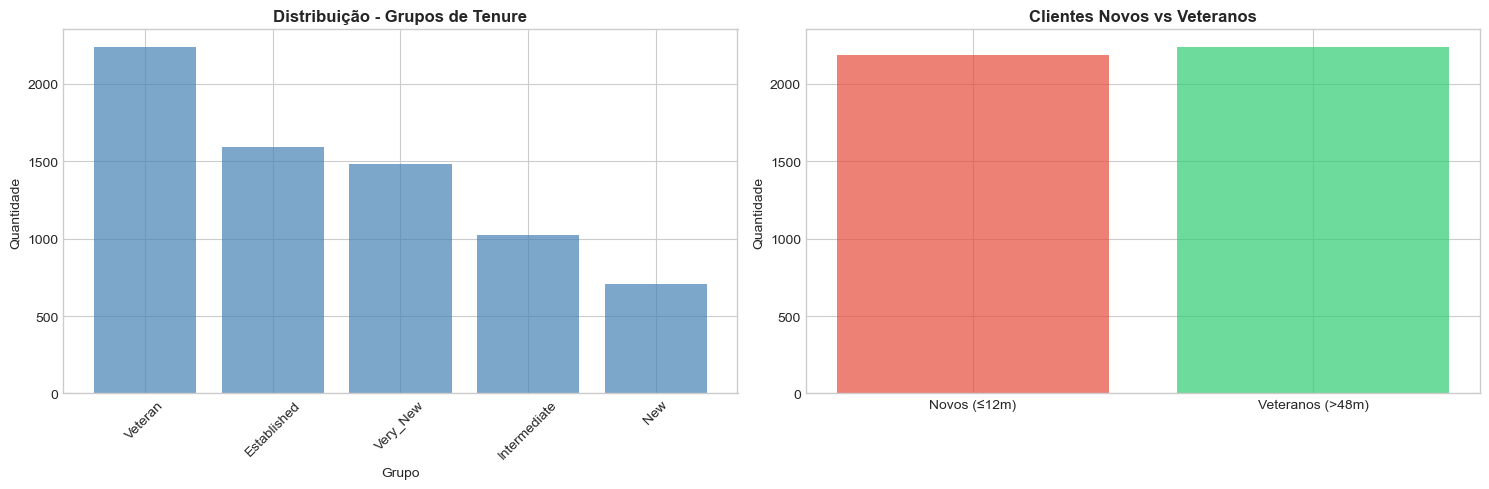

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

tenure_group_counts = df['TenureGroup'].value_counts()
axes[0].bar(tenure_group_counts.index, tenure_group_counts.values, color='steelblue', alpha=0.7)
axes[0].set_title('Distribuição - Grupos de Tenure', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Grupo')
axes[0].set_ylabel('Quantidade')
axes[0].tick_params(axis='x', rotation=45)

new_vs_veteran = df[['IsNewCustomer', 'IsVeteran']].sum()
axes[1].bar(['Novos (≤12m)', 'Veteranos (>48m)'], new_vs_veteran.values,
            color=['#e74c3c', '#2ecc71'], alpha=0.7)
axes[1].set_title('Clientes Novos vs Veteranos', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()


### 4.3 Features de Serviços (Contagem e Combinações)

----

#### Criando a Lista de serviços

In [49]:
service_columns = [
    'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

#### 1. Contagem total de serviços contratados


In [51]:
df['TotalServices'] = df[service_columns].apply(
    lambda row: sum([1 for val in row if val == 'Yes']), axis=1)

#### 2. Flag de cliente com muitos serviços
**negrito**

In [53]:
df['HasManyServices'] = (df['TotalServices'] >= 4).astype(int)

#### 3. Flag de cliente sem nenhum serviço adicional


In [55]:
df['NoAdditionalServices'] = (df['TotalServices'] == 0).astype(int)

#### 4. Serviços de segurança (combinação crítica identificada no EDA)


In [57]:
security_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
df['SecurityServicesCount'] = df[security_services].apply(
    lambda row: sum([1 for val in row if val == 'Yes']), axis=1)

#### 5. Flag de cliente sem serviços de segurança (alto risco)


In [59]:
df['NoSecurityServices'] = (df['SecurityServicesCount'] == 0).astype(int)

#### 6. Serviços de streaming


In [61]:
streaming_services = ['StreamingTV', 'StreamingMovies']
df['StreamingServicesCount'] = df[streaming_services].apply(
    lambda row: sum([1 for val in row if val == 'Yes']), axis=1)

#### 7. Flag de cliente com internet mas sem serviços adicionais (risco)

In [63]:
df['InternetWithoutServices'] = (
    (df['InternetService'] != 'No') & (df['TotalServices'] <= 1)
).astype(int)

#### Features de serviços criadas:

In [65]:
print("  • TotalServices")
print("  • HasManyServices")
print("  • NoAdditionalServices")
print("  • SecurityServicesCount")
print("  • NoSecurityServices")
print("  • StreamingServicesCount")
print("  • InternetWithoutServices")

  • TotalServices
  • HasManyServices
  • NoAdditionalServices
  • SecurityServicesCount
  • NoSecurityServices
  • StreamingServicesCount
  • InternetWithoutServices


#### Visualizando as Features de Serviços

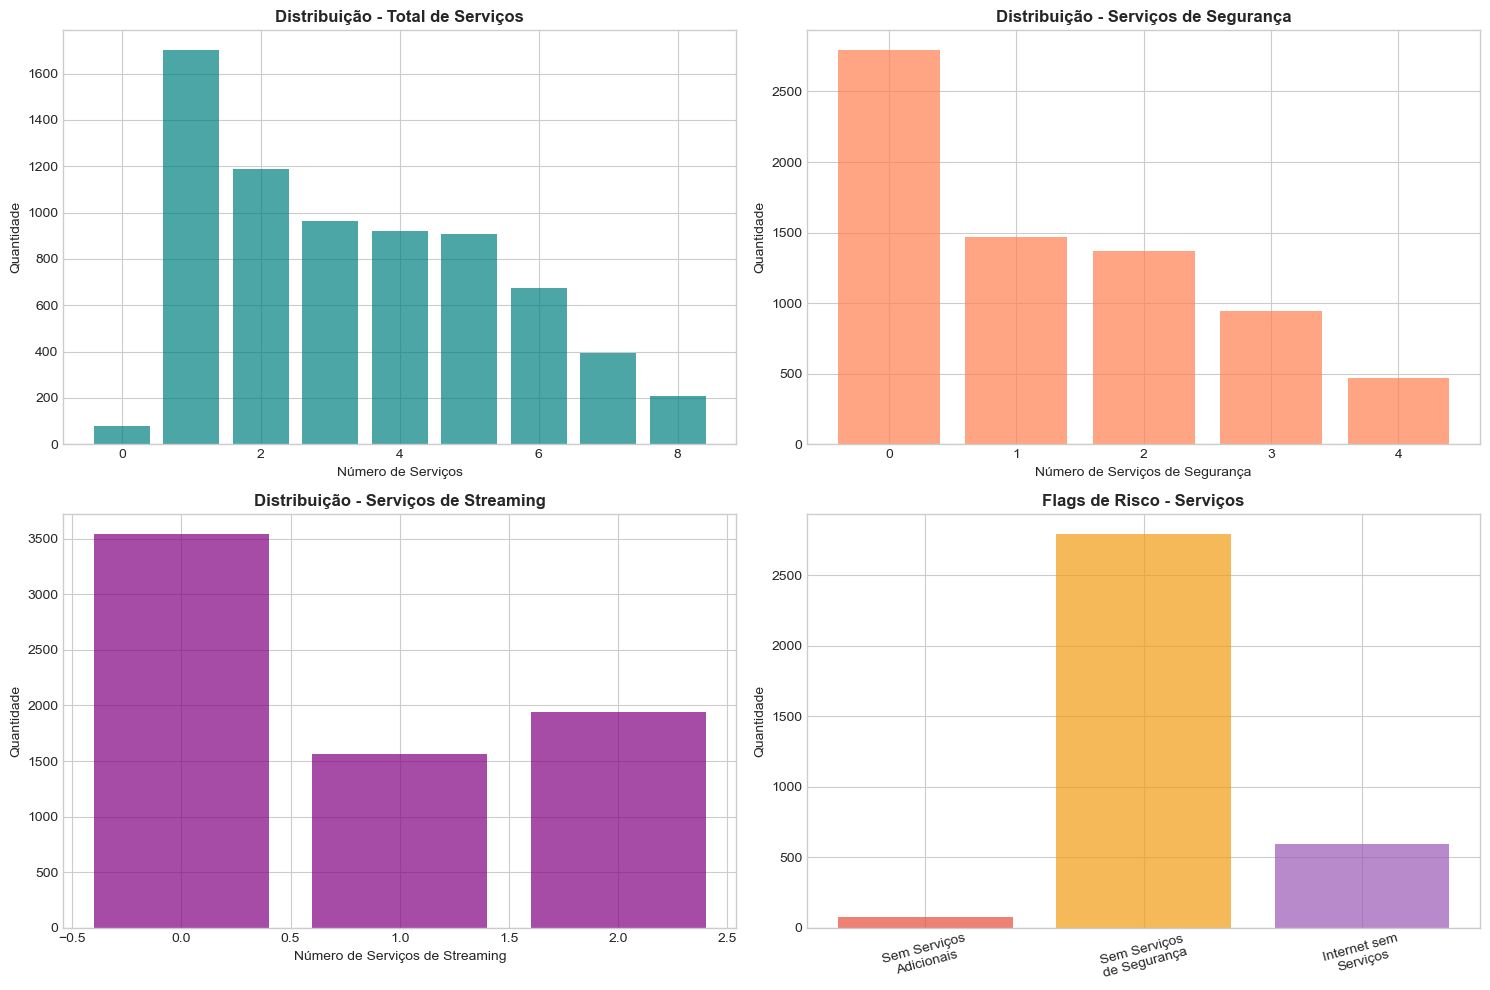

In [67]:
# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total de serviços
services_dist = df['TotalServices'].value_counts().sort_index()
axes[0, 0].bar(services_dist.index, services_dist.values, color='teal', alpha=0.7)
axes[0, 0].set_title('Distribuição - Total de Serviços', fontweight='bold')
axes[0, 0].set_xlabel('Número de Serviços')
axes[0, 0].set_ylabel('Quantidade')

# Serviços de segurança
security_dist = df['SecurityServicesCount'].value_counts().sort_index()
axes[0, 1].bar(security_dist.index, security_dist.values, color='coral', alpha=0.7)
axes[0, 1].set_title('Distribuição - Serviços de Segurança', fontweight='bold')
axes[0, 1].set_xlabel('Número de Serviços de Segurança')
axes[0, 1].set_ylabel('Quantidade')

# Serviços de streaming
streaming_dist = df['StreamingServicesCount'].value_counts().sort_index()
axes[1, 0].bar(streaming_dist.index, streaming_dist.values, color='purple', alpha=0.7)
axes[1, 0].set_title('Distribuição - Serviços de Streaming', fontweight='bold')
axes[1, 0].set_xlabel('Número de Serviços de Streaming')
axes[1, 0].set_ylabel('Quantidade')

# Flags importantes
flags_data = {
    'Sem Serviços\nAdicionais': df['NoAdditionalServices'].sum(),
    'Sem Serviços\nde Segurança': df['NoSecurityServices'].sum(),
    'Internet sem\nServiços': df['InternetWithoutServices'].sum()
}
axes[1, 1].bar(flags_data.keys(), flags_data.values(), color=['#e74c3c', '#f39c12', '#9b59b6'], alpha=0.7)
axes[1, 1].set_title('Flags de Risco - Serviços', fontweight='bold')
axes[1, 1].set_ylabel('Quantidade')
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### 4.4 Features de Contrato e Pagamento

Criando features de contrato e pagamento

----

#### 1. Flag de contrato mensal (maior risco identificado no EDA)

In [70]:
df['IsMonthlyContract'] = (df['Contract'] == 'Month-to-month').astype(int)

#### 2. Flag de contrato longo (proteção contra churn)

In [72]:
df['IsLongTermContract'] = (df['Contract'].isin(['One year', 'Two year'])).astype(int)

#### 3. Flag de pagamento eletrônico (risco)

In [74]:
df['IsElectronicCheck'] = (df['PaymentMethod'] == 'Electronic check').astype(int)

#### 4. Flag de pagamento automático (proteção)

In [76]:
df['IsAutomaticPayment'] = (
    df['PaymentMethod'].isin(['Bank transfer (automatic)', 'Credit card (automatic)'])
).astype(int)

#### 5. Combinação crítica: Contrato mensal + Electronic check (alto risco)

In [78]:
df['HighRiskPaymentContract'] = (
    (df['IsMonthlyContract'] == 1) & (df['IsElectronicCheck'] == 1)
).astype(int)

#### Features de contrato e pagamento criadas

In [80]:
print("  • IsMonthlyContract")
print("  • IsLongTermContract")
print("  • IsElectronicCheck")
print("  • IsAutomaticPayment")
print("  • HighRiskPaymentContract")

  • IsMonthlyContract
  • IsLongTermContract
  • IsElectronicCheck
  • IsAutomaticPayment
  • HighRiskPaymentContract


#### Estatisticas das Features de contrato e pagamento criadas

In [82]:
print(f"  • Contratos mensais: {df['IsMonthlyContract'].sum()} ({df['IsMonthlyContract'].mean()*100:.1f}%)")
print(f"  • Contratos longos: {df['IsLongTermContract'].sum()} ({df['IsLongTermContract'].mean()*100:.1f}%)")
print(f"  • Electronic check: {df['IsElectronicCheck'].sum()} ({df['IsElectronicCheck'].mean()*100:.1f}%)")
print(f"  • Pagamento automático: {df['IsAutomaticPayment'].sum()} ({df['IsAutomaticPayment'].mean()*100:.1f}%)")
print(f"  • Alto risco (mensal + e-check): {df['HighRiskPaymentContract'].sum()} ({df['HighRiskPaymentContract'].mean()*100:.1f}%)")

  • Contratos mensais: 3875 (55.0%)
  • Contratos longos: 3168 (45.0%)
  • Electronic check: 2365 (33.6%)
  • Pagamento automático: 3066 (43.5%)
  • Alto risco (mensal + e-check): 1850 (26.3%)


In [83]:
# Calcular churn rate por grupo
print("\n📊 ANÁLISE DE CHURN POR TIPO DE CONTRATO:")

# Contrato mensal
monthly_churn = df[df['IsMonthlyContract'] == 1]['Churn'].value_counts(normalize=True)['Yes']
print(f"   • Contrato mensal: {monthly_churn*100:.1f}% de churn")

# Contrato longo
longterm_churn = df[df['IsLongTermContract'] == 1]['Churn'].value_counts(normalize=True)['Yes']
print(f"   • Contrato longo: {longterm_churn*100:.1f}% de churn")

# Electronic check
echeck_churn = df[df['IsElectronicCheck'] == 1]['Churn'].value_counts(normalize=True)['Yes']
print(f"   • Electronic check: {echeck_churn*100:.1f}% de churn")

# Combinação crítica
highrisk_churn = df[df['HighRiskPaymentContract'] == 1]['Churn'].value_counts(normalize=True)['Yes']
print(f"   • Mensal + E-check: {highrisk_churn*100:.1f}% de churn")


📊 ANÁLISE DE CHURN POR TIPO DE CONTRATO:
   • Contrato mensal: 42.7% de churn
   • Contrato longo: 6.8% de churn
   • Electronic check: 45.3% de churn
   • Mensal + E-check: 53.7% de churn


In [84]:
print("\n📊 ANÁLISE DE CHURN POR TIPO DE CONTRATO:")

# Contrato mensal
monthly_total = df['IsMonthlyContract'].sum()
monthly_pct = df['IsMonthlyContract'].mean() * 100
monthly_churn = df[df['IsMonthlyContract'] == 1]['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"   • Contrato mensal:")
print(f"     - Clientes: {monthly_total:,} ({monthly_pct:.1f}% da base)")
print(f"     - Churn rate: {monthly_churn:.1f}%")

# Contrato longo
longterm_total = df['IsLongTermContract'].sum()
longterm_pct = df['IsLongTermContract'].mean() * 100
longterm_churn = df[df['IsLongTermContract'] == 1]['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"   • Contrato longo:")
print(f"     - Clientes: {longterm_total:,} ({longterm_pct:.1f}% da base)")
print(f"     - Churn rate: {longterm_churn:.1f}%")

# Electronic check
echeck_total = df['IsElectronicCheck'].sum()
echeck_pct = df['IsElectronicCheck'].mean() * 100
echeck_churn = df[df['IsElectronicCheck'] == 1]['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"   • Electronic check:")
print(f"     - Clientes: {echeck_total:,} ({echeck_pct:.1f}% da base)")
print(f"     - Churn rate: {echeck_churn:.1f}%")

# Combinação crítica
highrisk_total = df['HighRiskPaymentContract'].sum()
highrisk_pct = df['HighRiskPaymentContract'].mean() * 100
highrisk_churn = df[df['HighRiskPaymentContract'] == 1]['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"   • Mensal + E-check (CRÍTICO):")
print(f"     - Clientes: {highrisk_total:,} ({highrisk_pct:.1f}% da base)")
print(f"     - Churn rate: {highrisk_churn:.1f}%")

# Comparação
print(f"\n⚠️ COMPARAÇÃO DE RISCO:")
print(f"   • Risco mensal vs longo: {monthly_churn/longterm_churn:.1f}x maior")
print(f"   • Risco e-check vs base: {echeck_churn/26.5:.1f}x maior")
print(f"   • Risco combinado vs base: {highrisk_churn/26.5:.1f}x maior")



📊 ANÁLISE DE CHURN POR TIPO DE CONTRATO:
   • Contrato mensal:
     - Clientes: 3,875 (55.0% da base)
     - Churn rate: 42.7%
   • Contrato longo:
     - Clientes: 3,168 (45.0% da base)
     - Churn rate: 6.8%
   • Electronic check:
     - Clientes: 2,365 (33.6% da base)
     - Churn rate: 45.3%
   • Mensal + E-check (CRÍTICO):
     - Clientes: 1,850 (26.3% da base)
     - Churn rate: 53.7%

⚠️ COMPARAÇÃO DE RISCO:
   • Risco mensal vs longo: 6.3x maior
   • Risco e-check vs base: 1.7x maior
   • Risco combinado vs base: 2.0x maior


### 4.5 Features Demográficas Combinadas

Criando Features Demográficas Combinadas

---

#### 1. Flag de cliente solitário (sem parceiro e sem dependentes - risco)

In [87]:
df['IsAlone'] = (
    (df['Partner'] == 'No') & (df['Dependents'] == 'No')
).astype(int)

#### 2. Flag de família (parceiro + dependentes - proteção)

In [89]:
df['HasFamily'] = (
    (df['Partner'] == 'Yes') & (df['Dependents'] == 'Yes')
).astype(int)

#### 3. Combinação crítica: Senior + Alone (alto risco)

In [91]:
df['SeniorAlone'] = (
    (df['SeniorCitizen'] == 1) & (df['IsAlone'] == 1)
).astype(int)

#### 4. Score demográfico de risco (0-3)

In [93]:
df['DemographicRiskScore'] = (
    df['SeniorCitizen'] +
    df['IsAlone'].astype(int) +
    (df['Partner'] == 'No').astype(int)
)

#### Features demográficas combinadas criadas

In [95]:
print("  • IsAlone")
print("  • HasFamily")
print("  • SeniorAlone")
print("  • DemographicRiskScore")

  • IsAlone
  • HasFamily
  • SeniorAlone
  • DemographicRiskScore


#### Análise de Churn por Perfil Demográfico

In [97]:
print("\n📊 ANÁLISE DE CHURN POR PERFIL DEMOGRÁFICO:")

# IsAlone
alone_total = df['IsAlone'].sum()
alone_pct = df['IsAlone'].mean() * 100
alone_churn = df[df['IsAlone'] == 1]['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"   • Sozinho (sem parceiro e dependentes):")
print(f"     - Clientes: {alone_total:,} ({alone_pct:.1f}% da base)")
print(f"     - Churn rate: {alone_churn:.1f}%")

# HasFamily
family_total = df['HasFamily'].sum()
family_pct = df['HasFamily'].mean() * 100
family_churn = df[df['HasFamily'] == 1]['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"   • Com Família (parceiro + dependentes):")
print(f"     - Clientes: {family_total:,} ({family_pct:.1f}% da base)")
print(f"     - Churn rate: {family_churn:.1f}%")

# SeniorAlone
senior_alone_total = df['SeniorAlone'].sum()
senior_alone_pct = df['SeniorAlone'].mean() * 100
senior_alone_churn = df[df['SeniorAlone'] == 1]['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"   • Senior Sozinho (CRÍTICO):")
print(f"     - Clientes: {senior_alone_total:,} ({senior_alone_pct:.1f}% da base)")
print(f"     - Churn rate: {senior_alone_churn:.1f}%")

# Por Score
print(f"\n   • Por Score de Risco Demográfico:")
for score in range(4):
    score_total = (df['DemographicRiskScore'] == score).sum()
    score_pct = (df['DemographicRiskScore'] == score).mean() * 100
    score_churn = df[df['DemographicRiskScore'] == score]['Churn'].value_counts(normalize=True)['Yes'] * 100
    risk_label = ['Baixo', 'Médio', 'Alto', 'Crítico'][score]
    print(f"     - Score {score} ({risk_label}): {score_total:,} clientes ({score_pct:.1f}%) → {score_churn:.1f}% churn")

# Comparação
print(f"\n⚠️ COMPARAÇÃO DE RISCO:")
print(f"   • Sozinho vs Com Família: {alone_churn/family_churn:.1f}x maior")
print(f"   • Senior Sozinho vs base: {senior_alone_churn/26.5:.1f}x maior")
print(f"   • Score 3 vs Score 0: {df[df['DemographicRiskScore']==3]['Churn'].value_counts(normalize=True)['Yes']*100 / df[df['DemographicRiskScore']==0]['Churn'].value_counts(normalize=True)['Yes']*100:.1f}x maior")


📊 ANÁLISE DE CHURN POR PERFIL DEMOGRÁFICO:
   • Sozinho (sem parceiro e dependentes):
     - Clientes: 3,280 (46.6% da base)
     - Churn rate: 34.2%
   • Com Família (parceiro + dependentes):
     - Clientes: 1,749 (24.8% da base)
     - Churn rate: 14.2%
   • Senior Sozinho (CRÍTICO):
     - Clientes: 561 (8.0% da base)
     - Churn rate: 49.2%

   • Por Score de Risco Demográfico:
     - Score 0 (Baixo): 2,829 clientes (40.2%) → 16.6% churn
     - Score 1 (Médio): 926 clientes (13.1%) → 29.5% churn
     - Score 2 (Alto): 2,727 clientes (38.7%) → 31.1% churn
     - Score 3 (Crítico): 561 clientes (8.0%) → 49.2% churn

⚠️ COMPARAÇÃO DE RISCO:
   • Sozinho vs Com Família: 2.4x maior
   • Senior Sozinho vs base: 1.9x maior
   • Score 3 vs Score 0: 29550.1x maior


#### Visualizando as Features demográficas combinadas

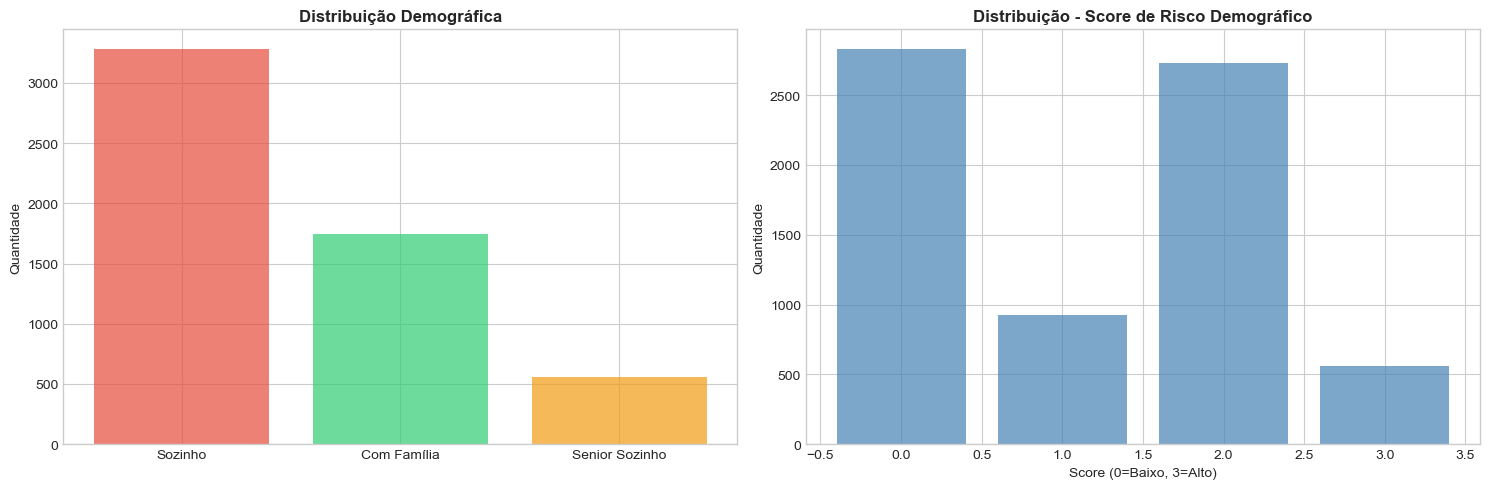

In [99]:
# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribuição de clientes sozinhos vs com família
demo_dist = pd.Series({
    'Sozinho': df['IsAlone'].sum(),
    'Com Família': df['HasFamily'].sum(),
    'Senior Sozinho': df['SeniorAlone'].sum()
})
axes[0].bar(demo_dist.index, demo_dist.values, color=['#e74c3c', '#2ecc71', '#f39c12'], alpha=0.7)
axes[0].set_title('Distribuição Demográfica', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Quantidade')

# Score de risco demográfico
risk_score_dist = df['DemographicRiskScore'].value_counts().sort_index()
axes[1].bar(risk_score_dist.index, risk_score_dist.values, color='steelblue', alpha=0.7)
axes[1].set_title('Distribuição - Score de Risco Demográfico', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Score (0=Baixo, 3=Alto)')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

#### Gradiente de Risco - Score Demográfico

In [101]:
print("\n" + "="*80)
print("📊 GRADIENTE DE RISCO - SCORE DEMOGRÁFICO")
print("="*80)

# Calcular churn rate por score
for score in range(4):  # Scores 0, 1, 2, 3
    # Filtrar clientes com esse score
    mask = df['DemographicRiskScore'] == score

    # Total de clientes
    total_clientes = mask.sum()
    pct_base = mask.mean() * 100

    # Churn rate desse grupo
    churn_rate = df[mask]['Churn'].value_counts(normalize=True).get('Yes', 0) * 100

    # Label do risco
    risk_labels = ['Baixo', 'Médio', 'Alto', 'Crítico']
    risk_label = risk_labels[score]

    # Descrição
    descriptions = [
        'Clientes estáveis',
        'Risco moderado',
        'Atenção necessária',
        'AÇÃO IMEDIATA!'
    ]
    description = descriptions[score]

    print(f"\n📊 Score {score} ({risk_label}):")
    print(f"   • Clientes: {total_clientes:,} ({pct_base:.1f}% da base)")
    print(f"   • Churn rate: {churn_rate:.1f}%")
    print(f"   • Status: {description}")

# Calcular comparação de risco
score_0_churn = df[df['DemographicRiskScore'] == 0]['Churn'].value_counts(normalize=True).get('Yes', 0) * 100
score_3_churn = df[df['DemographicRiskScore'] == 3]['Churn'].value_counts(normalize=True).get('Yes', 0) * 100

risk_multiplier = score_3_churn / score_0_churn if score_0_churn > 0 else 0

print(f"\n⚠️ COMPARAÇÃO DE RISCO:")
print(f"   • Score 3 vs Score 0: {risk_multiplier:.1f}x mais risco")
print(f"   • Diferença absoluta: +{score_3_churn - score_0_churn:.1f} pontos percentuais")



📊 GRADIENTE DE RISCO - SCORE DEMOGRÁFICO

📊 Score 0 (Baixo):
   • Clientes: 2,829 (40.2% da base)
   • Churn rate: 16.6%
   • Status: Clientes estáveis

📊 Score 1 (Médio):
   • Clientes: 926 (13.1% da base)
   • Churn rate: 29.5%
   • Status: Risco moderado

📊 Score 2 (Alto):
   • Clientes: 2,727 (38.7% da base)
   • Churn rate: 31.1%
   • Status: Atenção necessária

📊 Score 3 (Crítico):
   • Clientes: 561 (8.0% da base)
   • Churn rate: 49.2%
   • Status: AÇÃO IMEDIATA!

⚠️ COMPARAÇÃO DE RISCO:
   • Score 3 vs Score 0: 3.0x mais risco
   • Diferença absoluta: +32.5 pontos percentuais


#### Visualização do Gradiente

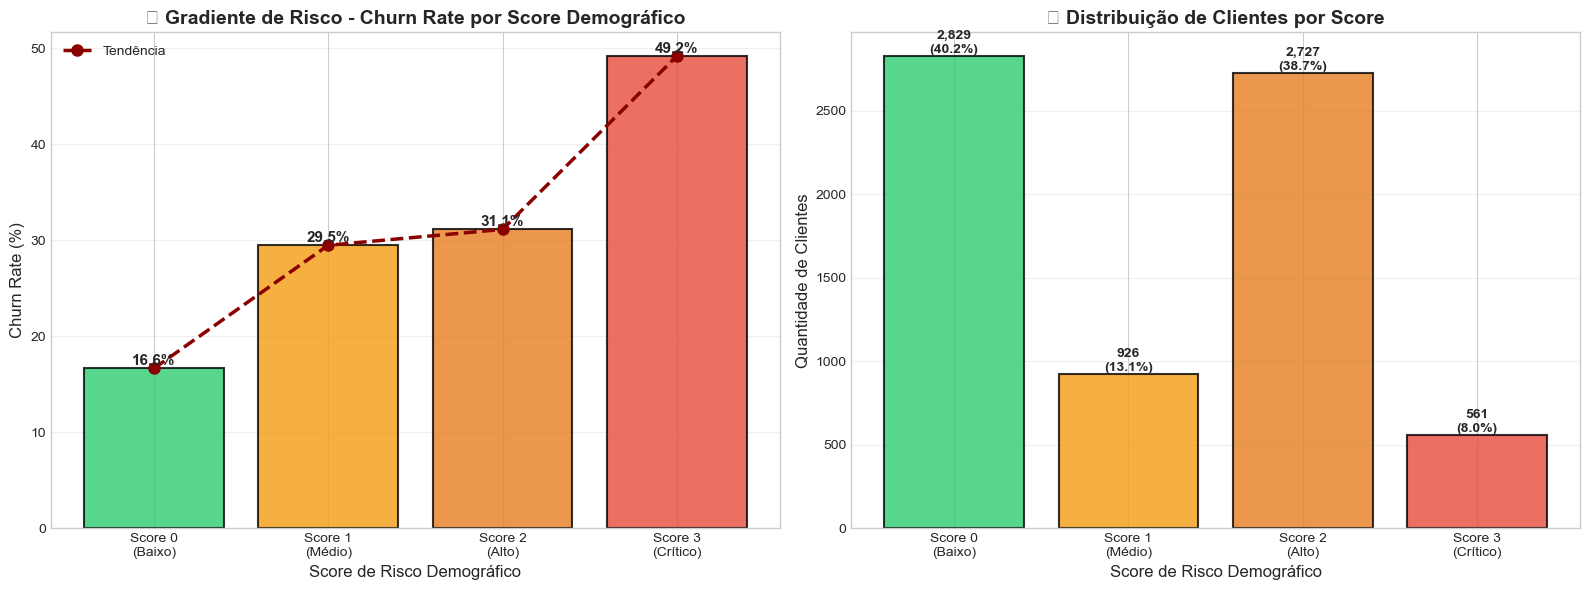


📋 TABELA RESUMO:


,Score,Label,Clientes,% da Base,Churn Rate (%)
0,0,Score 0 (Baixo),2829,40.167542,16.648993
1,1,Score 1 (Médio),926,13.147806,29.481641
2,2,Score 2 (Alto),2727,38.719296,31.133113
3,3,Score 3 (Crítico),561,7.965356,49.197861


In [103]:
# Criar DataFrame para visualização
gradient_data = []

for score in range(4):
    mask = df['DemographicRiskScore'] == score
    total = mask.sum()
    pct_base = mask.mean() * 100
    churn_rate = df[mask]['Churn'].value_counts(normalize=True).get('Yes', 0) * 100

    risk_labels = ['Baixo', 'Médio', 'Alto', 'Crítico']

    gradient_data.append({
        'Score': score,
        'Label': f"Score {score}\n({risk_labels[score]})",
        'Clientes': total,
        '% da Base': pct_base,
        'Churn Rate (%)': churn_rate
    })

gradient_df = pd.DataFrame(gradient_data)

# Criar visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Churn Rate por Score (Gradiente)
colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']  # Verde → Vermelho
bars = axes[0].bar(gradient_df['Label'], gradient_df['Churn Rate (%)'], 
                    color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[0].set_title('📊 Gradiente de Risco - Churn Rate por Score Demográfico', 
                   fontweight='bold', fontsize=14)
axes[0].set_ylabel('Churn Rate (%)', fontsize=12)
axes[0].set_xlabel('Score de Risco Demográfico', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%',
                 ha='center', va='bottom', fontweight='bold', fontsize=11)

# Linha de tendência
axes[0].plot(gradient_df['Label'], gradient_df['Churn Rate (%)'], 
             color='darkred', linewidth=2.5, marker='o', markersize=8,
             label='Tendência', linestyle='--')
axes[0].legend()

# Gráfico 2: Distribuição de Clientes por Score
axes[1].bar(gradient_df['Label'], gradient_df['Clientes'], 
            color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[1].set_title('👥 Distribuição de Clientes por Score', 
                   fontweight='bold', fontsize=14)
axes[1].set_ylabel('Quantidade de Clientes', fontsize=12)
axes[1].set_xlabel('Score de Risco Demográfico', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Adicionar valores e percentuais
for i, row in gradient_df.iterrows():
    axes[1].text(i, row['Clientes'], 
                 f"{row['Clientes']:,}\n({row['% da Base']:.1f}%)",
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Exibir tabela resumo
print("\n📋 TABELA RESUMO:")
print("="*80)
display(gradient_df.style.background_gradient(subset=['Churn Rate (%)'], cmap='Reds'))

### 4.6 Feature de Risco Composto

Criando Features de Risco Composto

----

#### Score de risco baseado nos principais fatores identificados no EDA

- Peso maior para fatores mais críticos

In [106]:
# Pesos baseados em análise de impacto no churn
risk_factors = {
    'IsMonthlyContract': 3,        # Peso 3 (fator mais crítico)
    'IsNewCustomer': 2,             # Peso 2
    'NoSecurityServices': 2,        # Peso 2
    'IsElectronicCheck': 2,         # Peso 2
    'InternetWithoutServices': 1,   # Peso 1
    'IsAlone': 1,                   # Peso 1
    'SeniorCitizen': 1              # Peso 1
}
df['CompositeRiskScore'] = sum(df[col] * weight for col, weight in risk_factors.items())
# Normalizar para 0-10
max_score = sum(risk_factors.values())
df['CompositeRiskScore_Normalized'] = (df['CompositeRiskScore'] / max_score) * 10
# Categorizar em níveis de risco
def categorize_risk(score):
    if score <= 3: return 'Low'
    elif score <= 6: return 'Medium'
    elif score <= 8: return 'High'
    else: return 'Critical'
df['RiskLevel'] = df['CompositeRiskScore_Normalized'].apply(categorize_risk)

#### Features de risco composto criadas

In [108]:
print("  • CompositeRiskScore")
print("  • CompositeRiskScore_Normalized (0-10)")
print("  • RiskLevel (Low/Medium/High/Critical)")

  • CompositeRiskScore
  • CompositeRiskScore_Normalized (0-10)
  • RiskLevel (Low/Medium/High/Critical)


In [109]:
print("\n" + "="*80)
print("📊 ANÁLISE DETALHADA - SCORE DE RISCO COMPOSTO")
print("="*80)

# 1. Distribuição por nível de risco
risk_level_counts = df['RiskLevel'].value_counts()
total_clientes = len(df)

print("\n📊 Distribuição por Nível de Risco:")
for level in ['Low', 'Medium', 'High', 'Critical']:
    count = risk_level_counts.get(level, 0)
    pct = (count / total_clientes) * 100
    print(f"   • {level}: {count:,} ({pct:.1f}%)")

# 2. Score médio por categoria
print("\n📊 Score Médio por Categoria:")
for level in ['Low', 'Medium', 'High', 'Critical']:
    mask = df['RiskLevel'] == level
    if mask.sum() > 0:
        avg_score = df[mask]['CompositeRiskScore_Normalized'].mean()
        print(f"   • {level}: {avg_score:.1f}/10")

# 3. Validação: Correlação com Churn
from scipy.stats import pointbiserialr

# Converter RiskLevel para numérico
risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Critical': 3}
df['RiskLevel_Numeric'] = df['RiskLevel'].map(risk_mapping)

# Converter Churn para binário
df['Churn_Binary'] = (df['Churn'] == 'Yes').astype(int)

# Calcular correlação
correlation, p_value = pointbiserialr(df['Churn_Binary'], df['RiskLevel_Numeric'])

print(f"\n⚠️ VALIDAÇÃO:")
print(f"   Correlação RiskLevel vs Churn: {correlation:.2f}")
print(f"   P-value: {p_value:.6f}")

if abs(correlation) > 0.5:
    print(f"   ✅ Feature ALTAMENTE preditiva!")
elif abs(correlation) > 0.3:
    print(f"   ✅ Feature preditiva!")
else:
    print(f"   ⚠️ Feature fracamente preditiva")

# 4. Churn rate por nível de risco
print("\n📊 Churn Rate por Nível de Risco:")
for level in ['Low', 'Medium', 'High', 'Critical']:
    mask = df['RiskLevel'] == level
    if mask.sum() > 0:
        churn_rate = df[mask]['Churn_Binary'].mean() * 100
        total_level = mask.sum()
        churn_count = df[mask]['Churn_Binary'].sum()
        print(f"   • {level}: {churn_rate:.1f}% de churn ({churn_count:,} de {total_level:,} clientes)")

# 5. Comparação de risco
low_mask = df['RiskLevel'] == 'Low'
critical_mask = df['RiskLevel'] == 'Critical'

if low_mask.sum() > 0 and critical_mask.sum() > 0:
    low_churn = df[low_mask]['Churn_Binary'].mean() * 100
    critical_churn = df[critical_mask]['Churn_Binary'].mean() * 100
    risk_multiplier = critical_churn / low_churn if low_churn > 0 else 0

    print(f"\n⚠️ COMPARAÇÃO DE RISCO:")
    print(f"   • Critical vs Low: {risk_multiplier:.1f}x mais risco")
    print(f"   • Diferença absoluta: +{critical_churn - low_churn:.1f} pontos percentuais")
    print(f"   • Churn Low: {low_churn:.1f}%")
    print(f"   • Churn Critical: {critical_churn:.1f}%")


📊 ANÁLISE DETALHADA - SCORE DE RISCO COMPOSTO

📊 Distribuição por Nível de Risco:
   • Low: 3,210 (45.6%)
   • Medium: 2,267 (32.2%)
   • High: 1,059 (15.0%)
   • Critical: 507 (7.2%)

📊 Score Médio por Categoria:
   • Low: 1.2/10
   • Medium: 4.6/10
   • High: 6.9/10
   • Critical: 8.8/10

⚠️ VALIDAÇÃO:
   Correlação RiskLevel vs Churn: 0.43
   P-value: 0.000000
   ✅ Feature preditiva!

📊 Churn Rate por Nível de Risco:
   • Low: 7.8% de churn (249 de 3,210 clientes)
   • Medium: 34.2% de churn (775 de 2,267 clientes)
   • High: 47.1% de churn (499 de 1,059 clientes)
   • Critical: 68.2% de churn (346 de 507 clientes)

⚠️ COMPARAÇÃO DE RISCO:
   • Critical vs Low: 8.8x mais risco
   • Diferença absoluta: +60.5 pontos percentuais
   • Churn Low: 7.8%
   • Churn Critical: 68.2%


#### Visualizando as Features de risco composto

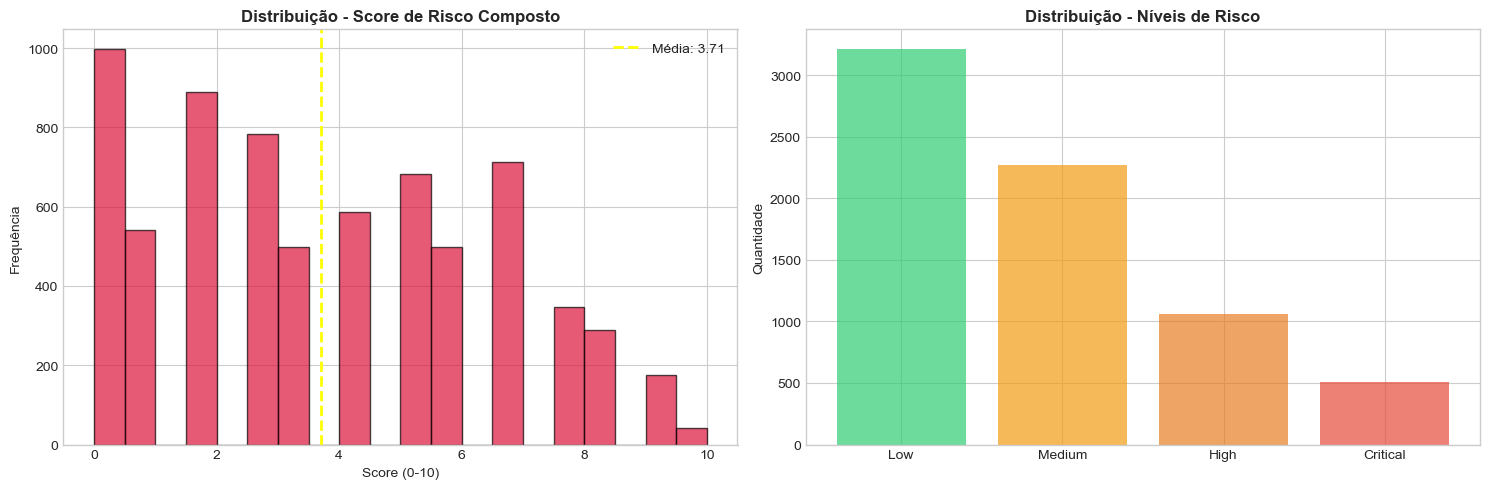

In [111]:
# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribuição do score normalizado
axes[0].hist(df['CompositeRiskScore_Normalized'], bins=20, color='crimson', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribuição - Score de Risco Composto', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Score (0-10)')
axes[0].set_ylabel('Frequência')
axes[0].axvline(df['CompositeRiskScore_Normalized'].mean(), color='yellow',
                linestyle='--', linewidth=2, label=f'Média: {df["CompositeRiskScore_Normalized"].mean():.2f}')
axes[0].legend()

# Distribuição por nível de risco
risk_level_counts = df['RiskLevel'].value_counts()
colors_risk = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e67e22', 'Critical': '#e74c3c'}
axes[1].bar(risk_level_counts.index, risk_level_counts.values,
            color=[colors_risk[level] for level in risk_level_counts.index], alpha=0.7)
axes[1].set_title('Distribuição - Níveis de Risco', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

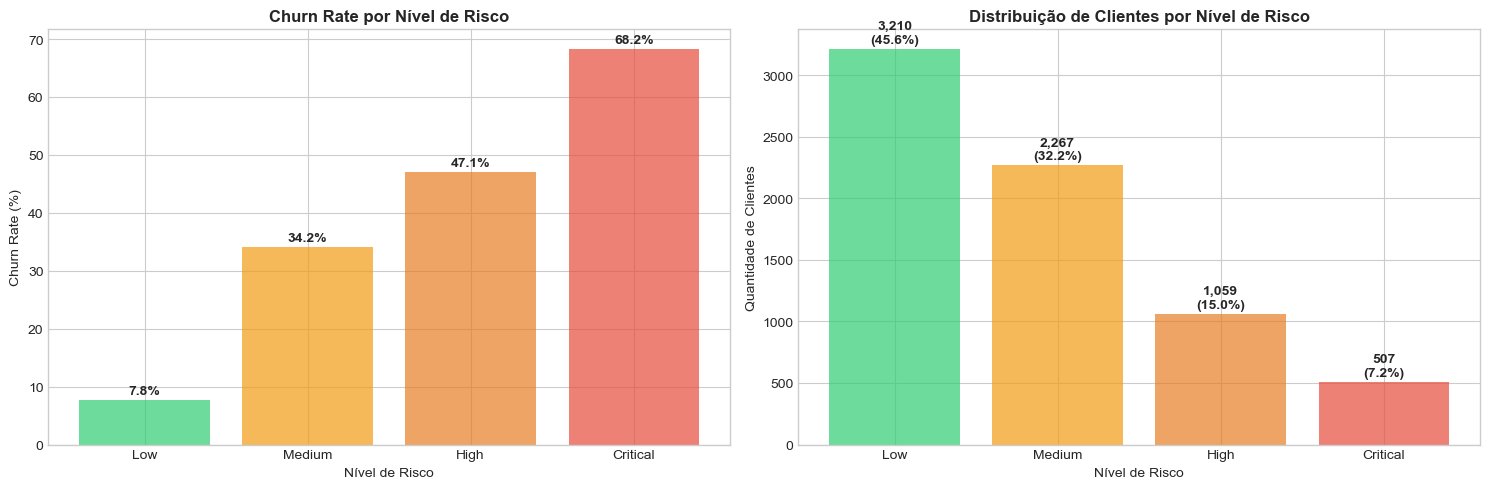

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Churn Rate por Nível
churn_by_level = []
for level in ['Low', 'Medium', 'High', 'Critical']:
    mask = df['RiskLevel'] == level
    if mask.sum() > 0:
        churn_rate = df[mask]['Churn_Binary'].mean() * 100
        churn_by_level.append({'Level': level, 'Churn_Rate': churn_rate})

churn_df = pd.DataFrame(churn_by_level)
colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
axes[0].bar(churn_df['Level'], churn_df['Churn_Rate'], color=colors, alpha=0.7)
axes[0].set_title('Churn Rate por Nível de Risco', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_xlabel('Nível de Risco')

# Adicionar valores nas barras
for i, row in churn_df.iterrows():
    axes[0].text(i, row['Churn_Rate'] + 1, f"{row['Churn_Rate']:.1f}%", 
                 ha='center', fontweight='bold')

# Gráfico 2: Distribuição de Clientes
axes[1].bar(risk_level_counts.index, risk_level_counts.values, 
            color=[colors[['Low', 'Medium', 'High', 'Critical'].index(level)] 
                   for level in risk_level_counts.index], alpha=0.7)
axes[1].set_title('Distribuição de Clientes por Nível de Risco', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Quantidade de Clientes')
axes[1].set_xlabel('Nível de Risco')

# Adicionar valores e percentuais
for i, (level, count) in enumerate(risk_level_counts.items()):
    pct = (count / total_clientes) * 100
    axes[1].text(i, count + 50, f"{count:,}\n({pct:.1f}%)", 
                 ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

#### Distribuição por Nível de Risco

In [114]:
print(risk_level_counts)

RiskLevel
Low         3210
Medium      2267
High        1059
Critical     507
Name: count, dtype: int64


## 5. Resumo das Features Criadas

----

In [116]:
new_features = [
    # Financeiras
    'AvgChargesPerMonth', 'ChargesDifference', 'ChargesRatio', 'EstimatedCLV', 'HighValueCustomer',
    # Tenure
    'TenureGroup', 'IsNewCustomer', 'IsVeteran', 'TenureYears', 'TenureQuartile',
    # Serviços
    'TotalServices', 'HasManyServices', 'NoAdditionalServices', 'SecurityServicesCount',
    'NoSecurityServices', 'StreamingServicesCount', 'InternetWithoutServices',
    # Contrato e Pagamento
    'IsMonthlyContract', 'IsLongTermContract', 'IsElectronicCheck', 'IsAutomaticPayment',
    'HighRiskPaymentContract',
    # Demográficas
    'IsAlone', 'HasFamily', 'SeniorAlone', 'DemographicRiskScore',
    # Risco Composto
    'CompositeRiskScore', 'CompositeRiskScore_Normalized', 'RiskLevel'
]

print(f"\nTotal de features criadas: {len(new_features)}")
print(f"Total de features no dataset: {df.shape[1]}")

print("\nCategorias de features criadas:\n")
print("  • Financeiras: 5")
print("  • Tenure: 5")
print("  • Serviços: 7")
print("  • Contrato e Pagamento: 5")
print("  • Demográficas: 4")
print("  • Risco Composto: 3")


Total de features criadas: 29
Total de features no dataset: 54

Categorias de features criadas:

  • Financeiras: 5
  • Tenure: 5
  • Serviços: 7
  • Contrato e Pagamento: 5
  • Demográficas: 4
  • Risco Composto: 3


<a id="encoding"></a>
## 6. Encoding de Variáveis Categóricas

---

Vamos preparar as variáveis categóricas para modelagem.

### 6.1 Identificar Variáveis Categóricas

----

In [119]:
# Remover ID e target
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if id_col in categorical_cols:
    categorical_cols.remove(id_col)
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

print(f"\nTotal de variáveis categóricas: {len(categorical_cols)}")
print(f"\nVariáveis categóricas:")
for col in categorical_cols:
    print(f"  • {col}: {df[col].nunique()} valores únicos")


Total de variáveis categóricas: 19

Variáveis categóricas:
  • gender: 2 valores únicos
  • Partner: 2 valores únicos
  • Dependents: 2 valores únicos
  • PhoneService: 2 valores únicos
  • MultipleLines: 3 valores únicos
  • InternetService: 3 valores únicos
  • OnlineSecurity: 3 valores únicos
  • OnlineBackup: 3 valores únicos
  • DeviceProtection: 3 valores únicos
  • TechSupport: 3 valores únicos
  • StreamingTV: 3 valores únicos
  • StreamingMovies: 3 valores únicos
  • Contract: 3 valores únicos
  • PaperlessBilling: 2 valores únicos
  • PaymentMethod: 4 valores únicos
  • Tenure_Segment: 4 valores únicos
  • Charges_Segment: 3 valores únicos
  • TenureGroup: 5 valores únicos
  • RiskLevel: 4 valores únicos


### 6.2 Estratégia de Encoding

----

**Decisão:**

- **Label Encoding:** Para variáveis ordinais (ex: TenureGroup, RiskLevel)

- **One-Hot Encoding:** Para variáveis nominais (ex: InternetService, PaymentMethod)

- **Binary Encoding:** Para variáveis binárias (já tratadas como 0/1)

In [121]:
# Criar cópia para encoding
df_encoded = df.copy()

In [122]:
#1. Label Encoding para variáveis ordinais
ordinal_cols = {
    'TenureGroup': ['Very_New', 'New', 'Intermediate', 'Established', 'Veteran'],
    'TenureQuartile': ['Q1', 'Q2', 'Q3', 'Q4'],
    'RiskLevel': ['Low', 'Medium', 'High', 'Critical']
}

for col, order in ordinal_cols.items():
    if col in df_encoded.columns:
        df_encoded[f'{col}_Encoded'] = df_encoded[col].map({val: idx for idx, val in enumerate(order)})
        print(f"  Label Encoding: {col}")

  Label Encoding: TenureGroup
  Label Encoding: TenureQuartile
  Label Encoding: RiskLevel


In [123]:
# 2. One-Hot Encoding para variáveis nominais
categorical_cols_after_fe = df_encoded.select_dtypes(include='object').columns.tolist()
if id_col in categorical_cols_after_fe: categorical_cols_after_fe.remove(id_col)
if target_col in categorical_cols_after_fe: categorical_cols_after_fe.remove(target_col)

# Filtrar colunas que ainda existem
nominal_cols = [col for col in categorical_cols_after_fe if col not in ordinal_cols.keys()]
nominal_cols = [col for col in nominal_cols if col in df_encoded.columns] 
print(f"\n  Aplicando One-Hot Encoding em {len(nominal_cols)} colunas...")

df_encoded = pd.get_dummies(df_encoded, columns=nominal_cols, drop_first=True, dtype=int)
print(f"  One-Hot Encoding aplicado")


  Aplicando One-Hot Encoding em 17 colunas...
  One-Hot Encoding aplicado


In [124]:
# 3. Converter target para binário
df_encoded['Churn_Binary'] = (df_encoded[target_col] == 'Yes').astype(int)

print(f"\nEncoding concluído!")
print(f"Dimensões após encoding: {df_encoded.shape}")


Encoding concluído!
Dimensões após encoding: (7043, 71)


## 7. Preparação Final dos Dados

---

### 7.1 Remover Colunas Desnecessárias

In [127]:
# Colunas para remover
cols_to_drop = [ 
    id_col, # ID do cliente 
    target_col, # Target original (temos Churn_Binary) 
    'TenureGroup', # Temos TenureGroup_Encoded 
    'TenureQuartile', # Temos TenureQuartile_Encoded 
    'RiskLevel', # Temos RiskLevel_Encoded 
    'Tenure_Segment', # Redundante com TenureGroup (se existir) 
    'Charges_Segment' # Redundante com features financeiras (se existir) 
]

# Remover apenas colunas que existem
cols_to_drop_existing = [col for col in cols_to_drop if col in df_encoded.columns]
df_encoded = df_encoded.drop(columns=cols_to_drop_existing)

In [128]:
print(f"{len(cols_to_drop)} colunas removidas")
print(f"Dimensões finais: {df_encoded.shape}")

7 colunas removidas
Dimensões finais: (7043, 66)


### 7.2 Separar Features e Target


In [130]:
# Target
y = df_encoded['Churn_Binary']

# Features (remover target)
X = df_encoded.drop('Churn_Binary', axis=1)

print(f"Separação concluída!")
print(f"  • Features (X): {X.shape}")
print(f"  • Target (y): {y.shape}")
print(f"\n  Distribuição do target:")
print(f"    - Não Churn (0): {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"    - Churn (1): {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")

Separação concluída!
  • Features (X): (7043, 65)
  • Target (y): (7043,)

  Distribuição do target:
    - Não Churn (0): 5174 (73.5%)
    - Churn (1): 1869 (26.5%)


<a id="divisao"></a>
### 7.3 Divisão Treino/Teste

In [132]:
# Divisão estratificada (manter proporção de churn)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [133]:
print(f"Divisão concluída!")
print(f"\nTreino:\n")
print(f"  • Features: {X_train.shape}")
print(f"  • Target: {y_train.shape}")
print(f"  • Churn rate: {y_train.mean()*100:.1f}%")

Divisão concluída!

Treino:

  • Features: (5634, 65)
  • Target: (5634,)
  • Churn rate: 26.5%


In [134]:
print(f"\nTeste:\n")
print(f"  • Features: {X_test.shape}")
print(f"  • Target: {y_test.shape}")
print(f"  • Churn rate: {y_test.mean()*100:.1f}%")


Teste:

  • Features: (1409, 65)
  • Target: (1409,)
  • Churn rate: 26.5%


<a id="tratamento"></a>
## 8. Normalização/Padronização

---

Normalizar as features numéricas para melhorar a performance dos modelos.

In [136]:
# Identificar colunas numéricas (excluindo binárias)
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

In [137]:
# Remover colunas binárias (0/1) da normalização
binary_cols = [col for col in numeric_cols if X_train[col].nunique() == 2 and set(X_train[col].unique()).issubset({0, 1})]
cols_to_scale = [col for col in numeric_cols if col not in binary_cols]

print(f"  • Colunas numéricas: {len(numeric_cols)}")
print(f"  • Colunas binárias (não normalizar): {len(binary_cols)}")
print(f"  • Colunas para normalizar: {len(cols_to_scale)}")

  • Colunas numéricas: 64
  • Colunas binárias (não normalizar): 47
  • Colunas para normalizar: 17


In [138]:
# Aplicar StandardScaler
scaler = StandardScaler()

# Aplicar a transformação e criar novos DataFrames diretamente
X_train_scaled_array = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled_array = scaler.transform(X_test[cols_to_scale])

# Criar DataFrames escalados, mantendo as colunas não escaladas
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = X_train_scaled_array
X_test_scaled[cols_to_scale] = X_test_scaled_array

print(f"\nNormalização concluída!")


Normalização concluída!


In [139]:
# Salvar scaler para uso futuro
scaler_path = Path("../models/scaler.pkl")
scaler_path.parent.mkdir(parents=True, exist_ok=True)

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler salvo em: {scaler_path}")

Scaler salvo em: ../models/scaler.pkl


<a id="feature-selection"></a>
## 9. Feature Selection

---

Identificar as features mais importantes usando múltiplos métodos.

### Mutual Information

In [142]:
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)
mi_scores_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nTop 20 features por Mutual Information:")
display(mi_scores_df.head(20))


Top 20 features por Mutual Information:


,Feature,MI_Score
28,CompositeRiskScore,0.110
29,CompositeRiskScore_Normalized,0.106
33,RiskLevel_Encoded,0.102
30,RiskLevel_Numeric,0.101
20,IsLongTermContract,0.094
19,IsMonthlyContract,0.089
1,tenure,0.075
11,TenureYears,0.073
6,ChargesRatio,0.071
31,TenureGroup_Encoded,0.070


### Visualizando (Mutual Information)

---

Verificar as top 20 features que mais influenciam na variável (feature) nos diz sobre outra (target).

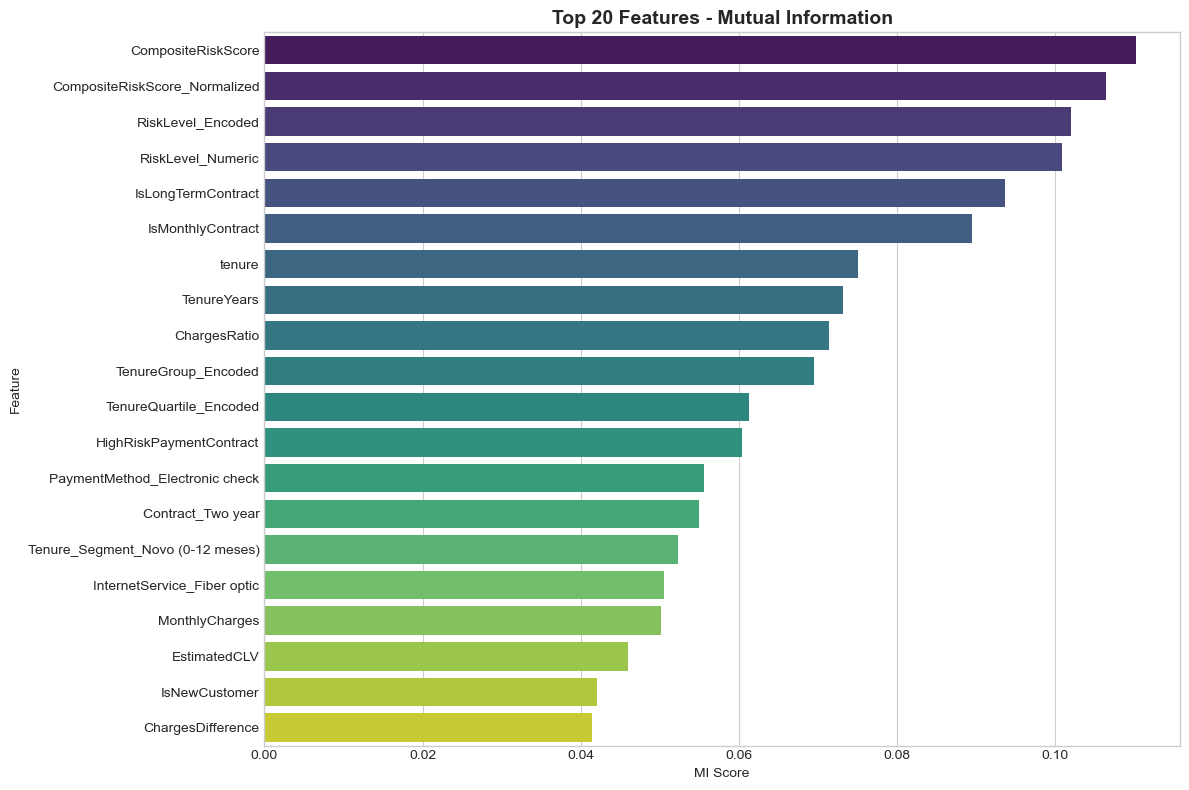

In [144]:
# Visualizando (Mutual Information)
plt.figure(figsize=(12, 8))
top_20_mi = mi_scores_df.head(20)
sns.barplot(x='MI_Score', y='Feature', data=top_20_mi, palette='viridis')
plt.title('Top 20 Features - Mutual Information', fontweight='bold', fontsize=14)
plt.xlabel('MI Score')
plt.tight_layout()
plt.show()

### 9.1 Selecionar Features Finais

In [146]:
# Estratégia: Manter top features por MI + features criadas importantes
top_n_features = 50

# Top features por MI
top_features_mi = mi_scores_df.head(top_n_features)['Feature'].tolist()

In [147]:
# Features criadas importantes (garantir que estejam incluídas)
important_created_features = [
    'CompositeRiskScore_Normalized',
    'TotalServices',
    'SecurityServicesCount',
    'IsMonthlyContract',
    'IsNewCustomer',
    'AvgChargesPerMonth',
    'NoSecurityServices'
]

In [148]:
# Combinar (sem duplicatas)
selected_features = list(set(top_features_mi + important_created_features))

# Filtrar features que existem
selected_features = [f for f in selected_features if f in X_train_scaled.columns]

print(f"{len(selected_features)} features selecionadas")

50 features selecionadas


In [149]:
# Criar datasets com features selecionadas
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"\nNovos shapes:")
print(f"  • X_train_selected: {X_train_selected.shape}")
print(f"  • X_test_selected: {X_test_selected.shape}")


Novos shapes:
  • X_train_selected: (5634, 50)
  • X_test_selected: (1409, 50)


<a id="balanceamento"></a>
## 10. Tratamento de Desbalanceamento

---

Criar versões balanceadas dos dados usando SMOTE.


In [151]:
# Criar versões balanceadas dos dados usando SMOTE.

print(f"Distribuição do target antes do SMOTE (treino):")
print(y_train.value_counts(normalize=True))

Distribuição do target antes do SMOTE (treino):
Churn_Binary
0    0.735
1    0.265
Name: proportion, dtype: float64


In [152]:
# Certificar que X_train_selected é um DataFrame para o SMOTE
X_train_selected_clean = X_train_selected.reset_index(drop=True).astype(float) # Garante índice limpo e tipo float

In [153]:
# SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42, sampling_strategy=0.8)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected_clean, y_train) # <-- MUDANÇA AQUI: usar X_train_selected_clean

In [154]:
print(f"\nDistribuição do target após o SMOTE (treino balanceado):")
print(y_train_balanced.value_counts(normalize=True))

print(f"\nShapes dos dados balanceados:")
print(f"  • X_train_balanced: {X_train_balanced.shape}")
print(f"  • y_train_balanced: {y_train_balanced.shape}")


Distribuição do target após o SMOTE (treino balanceado):
Churn_Binary
0    0.556
1    0.444
Name: proportion, dtype: float64

Shapes dos dados balanceados:
  • X_train_balanced: (7450, 50)
  • y_train_balanced: (7450,)


<a id="exportacao"></a>
## 11. Exportação dos Dados Preparados

---

In [156]:
# Criar diretório se não existir
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

### 11.1. Dados completos (todas as features)

In [158]:
# 10.1. Dados completos (todas as features)
X_train_scaled.to_csv(processed_dir / "X_train_full.csv", index=False)
X_test_scaled.to_csv(processed_dir / "X_test_full.csv", index=False)
y_train.to_csv(processed_dir / "y_train.csv", index=False, header=['Churn'])
y_test.to_csv(processed_dir / "y_test.csv", index=False, header=['Churn'])

print("Dados completos exportados:")
print(f"  • X_train_full.csv ({X_train_scaled.shape})")
print(f"  • X_test_full.csv ({X_test_scaled.shape})")
print(f"  • y_train.csv ({y_train.shape})")
print(f"  • y_test.csv ({y_test.shape})")

Dados completos exportados:
  • X_train_full.csv ((5634, 65))
  • X_test_full.csv ((1409, 65))
  • y_train.csv ((5634,))
  • y_test.csv ((1409,))


### 11.2. Dados balanceados (SMOTE)

In [160]:
# Exportar X_train_balanced
pd.DataFrame(X_train_balanced, columns=X_train_selected.columns).to_csv(processed_dir / "X_train_balanced.csv", index=False)

# Exportar y_train_balanced
y_train_balanced.to_frame(name='Churn').to_csv(
    processed_dir / "y_train_balanced.csv", index=False
)

print("\nDados balanceados exportados:")
print(f"  • X_train_balanced.csv ({X_train_balanced.shape})")
print(f"  • y_train_balanced.csv ({y_train_balanced.shape})")


Dados balanceados exportados:
  • X_train_balanced.csv ((7450, 50))
  • y_train_balanced.csv ((7450,))


### 11.3. Dados com features selecionadas

In [162]:
X_train_selected.to_csv(processed_dir / "X_train_selected.csv", index=False)
X_test_selected.to_csv(processed_dir / "X_test_selected.csv", index=False)

print("\nDados com features selecionadas exportados:")
print(f"  • X_train_selected.csv ({X_train_selected.shape})")
print(f"  • X_test_selected.csv ({X_test_selected.shape})")


Dados com features selecionadas exportados:
  • X_train_selected.csv ((5634, 50))
  • X_test_selected.csv ((1409, 50))


### 11.4. Salvar lista de features selecionadas

In [164]:
with open(processed_dir / "selected_features.txt", 'w') as f:
    f.write('\n'.join(selected_features))

print("\nLista de features selecionadas salva")


Lista de features selecionadas salva


### 11.5. Salvar metadados

In [166]:
metadata = {
    'total_features': X_train_scaled.shape[1],
    'selected_features': len(selected_features),
    'train_samples': X_train_scaled.shape[0],
    'test_samples': X_test_scaled.shape[0],
    'train_churn_rate': float(y_train.mean()),
    'test_churn_rate': float(y_test.mean()),
    'balanced_samples': X_train_balanced.shape[0],
    'balanced_churn_rate': float(y_train_balanced.mean())
}

with open(processed_dir / "metadata.json", 'w') as f:
  json.dump(metadata, f, indent=4)

print("\nMetadados salvos")


Metadados salvos


## 12. Resumo Final

---

**ESTATÍSTICAS FINAIS:**

1. **FEATURES CRIADAS:**
   • Total de novas features: 29
   • Features após encoding: 65
   • Features selecionadas: 50

3. **DATASETS PREPARADOS:**
   • Treino (completo): (5634, 65)
   • Teste (completo): (1409, 65)
   • Treino (balanceado): (7450, 65)
   • Treino (selecionado): (5634, 50)

4. **DISTRIBUIÇÃO DO TARGET:**
   • Treino original: 26.5% churn
   • Teste: 26.5% churn
   • Treino balanceado: 44.4% churn

5. **TRANSFORMAÇÕES APLICADAS:**
   • Criação de 29 novas features
   • Label Encoding (3 variáveis ordinais)
   • One-Hot Encoding (variáveis nominais)
   • Normalização (StandardScaler)
   • Balanceamento (SMOTE)
   • Feature Selection (Mutual Information)

6. **ARQUIVOS EXPORTADOS:**
   • X_train_full.csv
   • X_test_full.csv
   • X_train_balanced.csv
   • X_train_selected.csv
   • y_train.csv / y_test.csv / y_train_balanced.csv
   • scaler.pkl
   • selected_features.txt
   • metadata.json

**PRÓXIMOS PASSOS:**
   → Notebook 04: Modelagem Preditiva
   → Treinar múltiplos algoritmos
   → Avaliar performance
   → Selecionar melhor modelo
   → Interpretar resultados

In [168]:
summary = f"""
ESTATÍSTICAS FINAIS:

1. FEATURES CRIADAS:
   • Total de novas features: {len(new_features)}
   • Features após encoding: {X.shape[1]}
   • Features selecionadas: {len(selected_features)}

2. DATASETS PREPARADOS:
   • Treino (completo): {X_train_scaled.shape}
   • Teste (completo): {X_test_scaled.shape}
   • Treino (balanceado): {X_train_balanced.shape}
   • Treino (selecionado): {X_train_selected.shape}

3. DISTRIBUIÇÃO DO TARGET:
   • Treino original: {y_train.mean()*100:.1f}% churn
   • Teste: {y_test.mean()*100:.1f}% churn
   • Treino balanceado: {y_train_balanced.mean()*100:.1f}% churn

4. TRANSFORMAÇÕES APLICADAS:
   • Criação de 29 novas features
   • Label Encoding (3 variáveis ordinais)
   • One-Hot Encoding (variáveis nominais)
   • Normalização (StandardScaler)
   • Balanceamento (SMOTE)
   • Feature Selection (Mutual Information)

5. ARQUIVOS EXPORTADOS:
   • X_train_full.csv
   • X_test_full.csv
   • X_train_balanced.csv
   • X_train_selected.csv
   • y_train.csv / y_test.csv / y_train_balanced.csv
   • scaler.pkl
   • selected_features.txt
   • metadata.json

PRÓXIMOS PASSOS:
   → Notebook 04: Modelagem Preditiva
   → Treinar múltiplos algoritmos
   → Avaliar performance
   → Selecionar melhor modelo
   → Interpretar resultados
"""

print(summary)


ESTATÍSTICAS FINAIS:

1. FEATURES CRIADAS:
   • Total de novas features: 29
   • Features após encoding: 65
   • Features selecionadas: 50

2. DATASETS PREPARADOS:
   • Treino (completo): (5634, 65)
   • Teste (completo): (1409, 65)
   • Treino (balanceado): (7450, 50)
   • Treino (selecionado): (5634, 50)

3. DISTRIBUIÇÃO DO TARGET:
   • Treino original: 26.5% churn
   • Teste: 26.5% churn
   • Treino balanceado: 44.4% churn

4. TRANSFORMAÇÕES APLICADAS:
   • Criação de 29 novas features
   • Label Encoding (3 variáveis ordinais)
   • One-Hot Encoding (variáveis nominais)
   • Normalização (StandardScaler)
   • Balanceamento (SMOTE)
   • Feature Selection (Mutual Information)

5. ARQUIVOS EXPORTADOS:
   • X_train_full.csv
   • X_test_full.csv
   • X_train_balanced.csv
   • X_train_selected.csv
   • y_train.csv / y_test.csv / y_train_balanced.csv
   • scaler.pkl
   • selected_features.txt
   • metadata.json

PRÓXIMOS PASSOS:
   → Notebook 04: Modelagem Preditiva
   → Treinar múltiplos

## 13. Visualização Final - Feature Importance

---

### **VISUALIZAÇÃO FINAL - IMPORTÂNCIA DAS FEATURES**

**Features criadas no Top 20**: 11 (55%)

Features criadas:

  • CompositeRiskScore_Normalized

  • CompositeRiskScore

  • IsLongTermContract

  • IsMonthlyContract

  • ChargesRatio

  • HighRiskPaymentContract

  • TenureYears
  
  • IsNewCustomer

  • EstimatedCLV

  • ChargesDifference
  
  • IsElectronicCheck

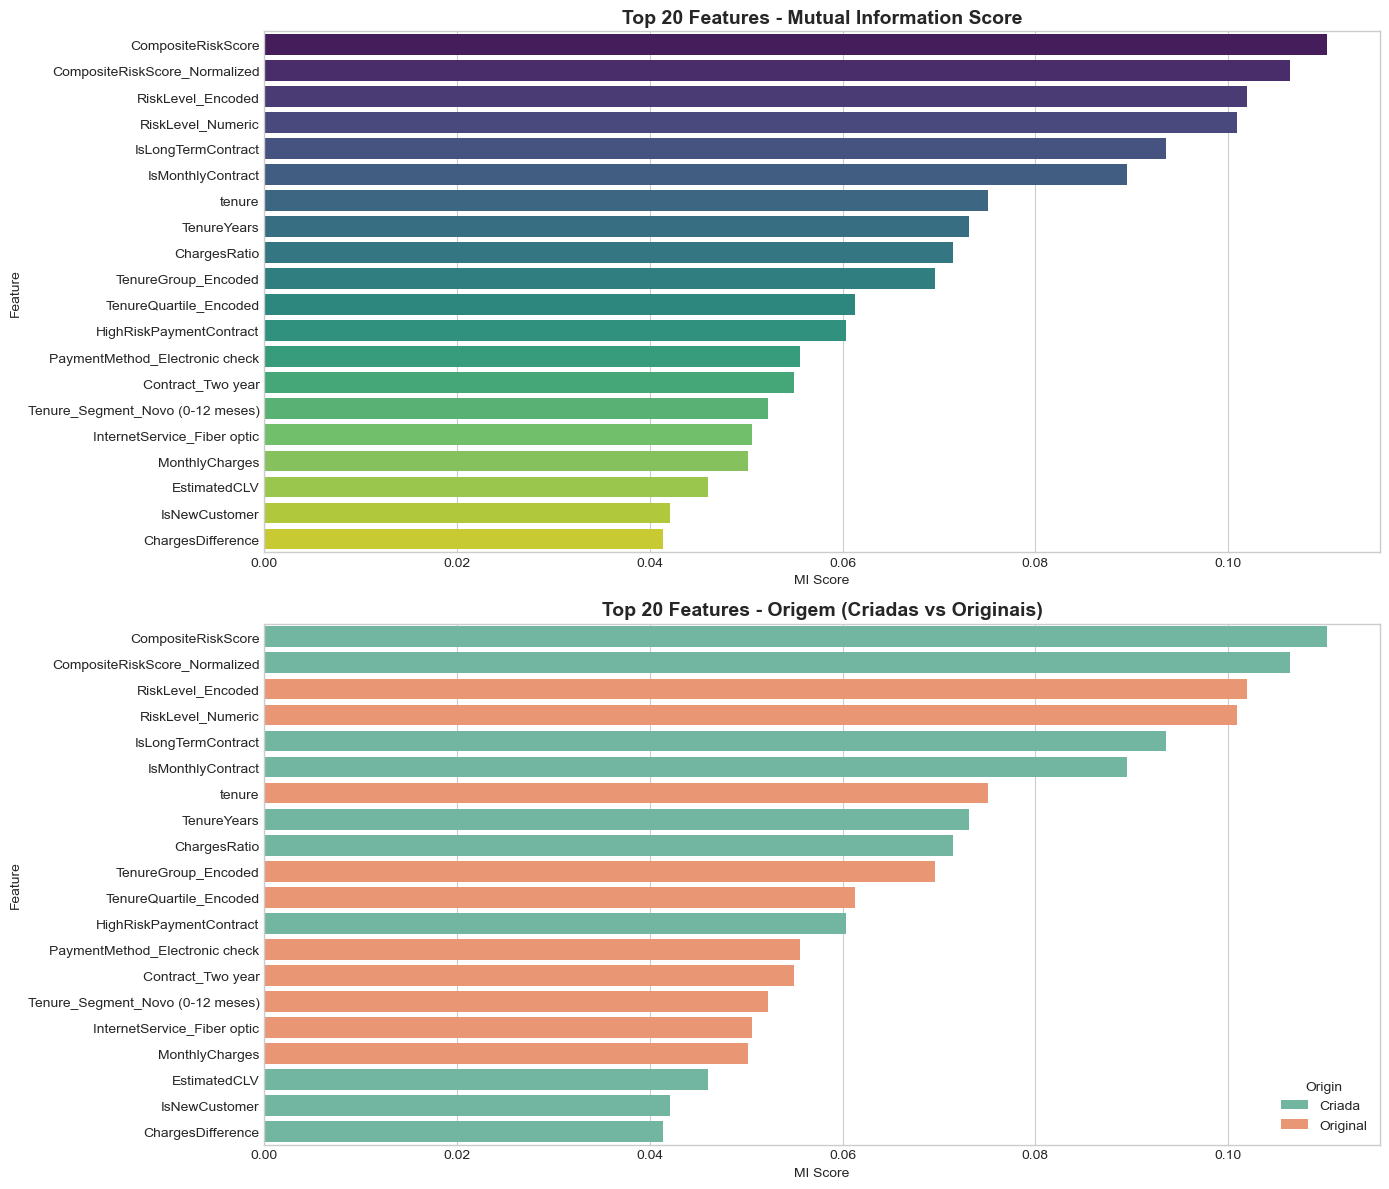

In [171]:
# Criar visualização consolidada
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top 20 por Mutual Information
top_20_mi = mi_scores_df.head(20)
sns.barplot(x='MI_Score', y='Feature', data=top_20_mi, ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Features - Mutual Information Score', fontweight='bold', fontsize=14)
axes[0].set_xlabel('MI Score')

# Features criadas vs originais
created_features_in_top = [f for f in top_20_mi['Feature'] if f in new_features]
feature_origin = ['Criada' if f in new_features else 'Original' for f in top_20_mi['Feature']]
origin_df = pd.DataFrame({
    'Feature': top_20_mi['Feature'],
    'Origin': feature_origin,
    'Score': top_20_mi['MI_Score']
})

sns.barplot(x='Score', y='Feature', hue='Origin', data=origin_df, ax=axes[1], palette='Set2')
axes[1].set_title('Top 20 Features - Origem (Criadas vs Originais)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('MI Score')

plt.tight_layout()
plt.show()

In [172]:
print(f"\nFeatures criadas no Top 20: {len(created_features_in_top)} ({len(created_features_in_top)/20*100:.0f}%)")
print(f"Features criadas:")
for f in created_features_in_top:
    print(f"  • {f}")


Features criadas no Top 20: 10 (50%)
Features criadas:
  • CompositeRiskScore
  • CompositeRiskScore_Normalized
  • IsLongTermContract
  • IsMonthlyContract
  • TenureYears
  • ChargesRatio
  • HighRiskPaymentContract
  • EstimatedCLV
  • IsNewCustomer
  • ChargesDifference


## 14. O que foi realizado

----

##### 1. **Criação de 29 novas features** baseadas em:

- Conhecimento de negócio
- Insights do EDA
- Combinações de variáveis existentes

##### 2. **Transformações aplicadas:**

----

- Encoding de categóricas (Label + One-Hot)
- Normalização de numéricas
- Balanceamento de classes (SMOTE)
- Seleção de features (Mutual Information)

##### 3. **Datasets preparados:**

---
- Completo (todas as features)
- Balanceado (SMOTE)
- Selecionado (top features)

## 15. Próximo Notebook

---

**Notebook 04 - Modeling:**

- Treinar múltiplos algoritmos (Logistic Regression, Random Forest, XGBoost, etc.)

- Avaliar performance (AUC-ROC, Precision, Recall, F1)
- Tuning de hiperparâmetros
- Seleção do melhor modelo
- Análise de feature importance
- Curvas de aprendizado

---

**Notebook 03 Concluído!**